In [1]:
import fair 

In [2]:
import numpy as np
from scipy import stats
from scipy import signal
import pandas as pd
from matplotlib import pyplot as plt


In [3]:
from scipy import stats
from fair.tools.ensemble import tcrecs_generate
from fair.forward import fair_scm

In [1]:
from functions import *

In [4]:

def make_params(n=100):
    samples = n

    # generate some joint lognormal TCR and ECS pairs
    tcrecs = tcrecs_generate(n=samples, seed=38571)

    # generate some forcing scale factors with SD of 10% of the best estimate
    # Chris: this is over-constrained and probably just something from my example
    # Instead let's repeat what we did in FaIR 1.3 code, component by component
    # using AR5 scalings
    zscore = stats.norm.ppf(0.95)
    scales1d = np.array(
        [
            0.2,      # CO2
            0.28,     # CH4: updated value from etminan 2016
            0.2,      # N2O
            0.2,      # other WMGHS
            0.4-0.2,        # tropospheric O3
            -0.05-(-0.15),  # stratospheric O3
            0.07-0.02,      # stratospheric WV from CH4
            1,              # contrails (lognormal)
            0.8/0.9,  # aerosols
            1,      # black carbon on snow (lognormal)
            -0.15-(-0.25),  # land use change
            1.0-0.5,        # volcanic
            0.05
        ]
    )/zscore # solar (additive)
    scales2d = np.repeat(scales1d[np.newaxis,:],samples,axis=0)

    locs = np.array([1,1,1,1,0.4,-0.05,0.07,1,1,1,-0.15,1.0,0.00])
    locs2d = np.repeat(locs[np.newaxis,:],samples,axis=0)

    # BC-snow and contrails are lognormal with sigma=0.5 and sigma=0.65: see page 8SM-11
    F_scale = stats.norm.rvs(size=(samples,13), loc=locs2d[:,:13], scale=scales2d[:,:13], random_state=40000)
    F_scale[:,9] = stats.lognorm.rvs(0.5, size=samples, random_state=40001)
    F_scale[:,7]  = stats.lognorm.rvs(0.65, size=samples, random_state=40002)

    # aerosols are asymmetric Gaussian
    F_scale[F_scale[:,8]<-0.9,8] = 1./0.8*(F_scale[F_scale[:,8]<-0.9,8]+0.9) - 0.9


    #F_scale = stats.norm.rvs(size=(samples,13), loc=1, scale=0.1, random_state=40000)

    # do the same for the carbon cycle parameters
    r0 = stats.norm.rvs(size=samples, loc=35, scale=3.5, random_state=41000)
    rc = stats.norm.rvs(size=samples, loc=0.019, scale=0.0019, random_state=42000)
    rt = stats.norm.rvs(size=samples, loc=4.165, scale=0.4165, random_state=45000)


    pmat=[]
    for i in range(n):
        p={}
        p['tcrecs']=tcrecs[i]
        p['F_scale']=F_scale[i,:]
        p['r0']=r0[i]
        p['rc']=rc[i]
        p['rt']=rt[i]
        pmat.append(p)
    return pmat

    




In [5]:
fair._version.get_versions()['version']

'1.6.4'

In [6]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
from fair.SSPs import ssp370, ssp126, ssp585, ssp119,ssp245,ssp534, ssp460

In [7]:
samples=1000

In [8]:
pmat0=make_params(n=samples)

In [9]:

Te=np.zeros((len(ssp585.Emissions.emissions),1000))
for i in range(samples):
    _, _, Te[:,i] = fair.forward.fair_scm(emissions=ssp585.Emissions.emissions,
                            r0 = pmat0[i]['r0'],
                            rc = pmat0[i]['rc'],
                            rt = pmat0[i]['rt'],
                            tcrecs = pmat0[i]['tcrecs'][:],
                            scale = pmat0[i]['F_scale'][:])

/Users/bensan/Documents/Github/SRMfair/.venv/lib/python3.12/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


KeyboardInterrupt: 

In [ ]:
#Follow Smith et al to constrain output based on CW
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

from fair.tools.constrain import hist_temp

# load up Cowtan and Way data remotely
url = 'http://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt'
response = urlopen(url)

CW = np.loadtxt(response)
constrained = np.zeros(samples, dtype=bool)

for i in range(samples):
    # we use observed trend from 1880 to 2016
    constrained[i], _, _, _, _ = hist_temp(CW[30:167,1], Te[1880-1765:2017-1765,i], CW[30:167,0])

# How many ensemble members passed the constraint?
print('%d ensemble members passed historical constraint' % np.sum(constrained))

319 ensemble members passed historical constraint


In [ ]:
pmat=[pmat0[i] for i in range(samples) if constrained[i]]

(0.0, 3.0)

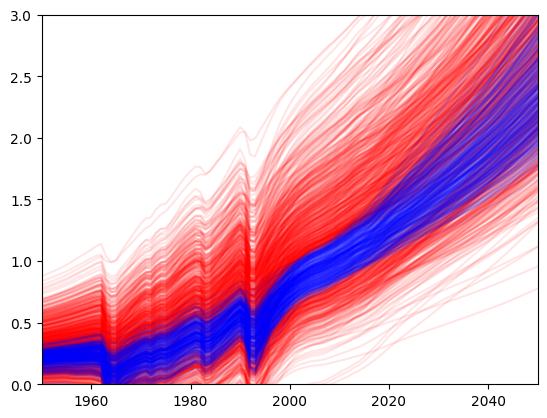

In [ ]:
plt.plot(yr,Te[:,~constrained],color='r',alpha=0.1)

plt.plot(yr,Te[:,constrained],color='b',alpha=0.1)

plt.xlim([1950,2050])
plt.ylim([0,3])

In [ ]:
import copy

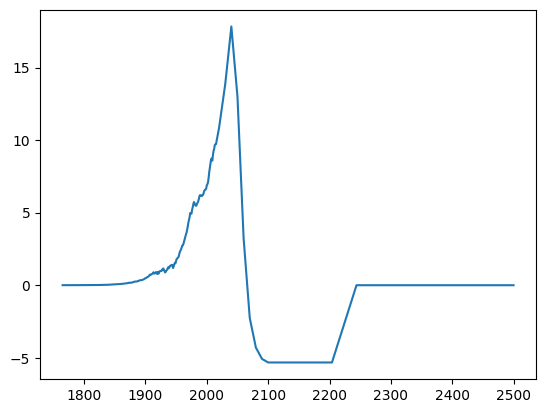

In [ ]:
ssp3ext=copy.deepcopy(ssp534)
ssp3ext.Emissions.emissions[340:,1]=ssp3ext.Emissions.emissions[340,1]
ssp3ext.Emissions.emissions[440:480,1]=ssp3ext.Emissions.emissions[340,1]*(1-np.arange(1,41,1)/40)
ssp3ext.Emissions.emissions[480:,1]=0

plt.plot(ssp3ext.Emissions.emissions[:,0],ssp3ext.Emissions.emissions[:,1])


In [ ]:
yrs=np.arange(2020,2300)
ems_bs=np.sum(ssp3ext.Emissions.emissions[:,1:3],axis=1)
C34, F34, T34 = fair.forward.fair_scm(emissions=ssp3ext.Emissions.emissions)

f_bs=np.sum(F34[:,1:11], axis=1)
yr=ssp370.Emissions.emissions[:,0]
C45g0, F45g0, T45g0 = fair.forward.fair_scm(emissions=ems_bs,other_rf=f_bs,useMultigas=False)

In [ ]:

def generate_efficacy(mean, length):
    # Ensure the mean is between 0 and 1
    if not (0 <= mean <= 1):
        raise ValueError("Mean must be between 0 and 1")
    
    # Generate a random sequence
    alpha = mean * 10
    beta = (1 - mean) * 10
    sequence = np.random.beta(alpha, beta, length)
    
    return sequence




In [ ]:
def find_consecutive_zeros(arr):
    consecutive_zeros = []
    current_zeros = []

    for i, value in enumerate(arr):
        if value == 0:
            current_zeros.append(i)
        else:
            if current_zeros:
                consecutive_zeros.append(current_zeros)
                current_zeros = []

    if current_zeros:
        consecutive_zeros.append(current_zeros)

    return consecutive_zeros


In [ ]:
import numpy as np

def simulate_failure(prob_failure=0.01, avg_outage_length=10, total_years=100,mean_efficacy=0.001):
    if not (0 <= mean_efficacy <= 1):
        raise ValueError("Mean must be between 0 and 1")
    alpha = mean_efficacy * 10
    beta = (1 - mean_efficacy) * 10

    failures = np.random.rand(total_years) < prob_failure
    outage_lengths = np.random.poisson(avg_outage_length, total_years)
    efficacy = np.random.beta(alpha, beta, total_years)
    failure_sequence = np.zeros(total_years)
    fracfail = np.zeros(total_years)+1
    
    for i in range(total_years):
        if failures[i]:
            failure_sequence[i:i+outage_lengths[i]] = 1
    list_periods=find_consecutive_zeros(failure_sequence)
    for i in range(len(list_periods)):
        if len(list_periods[i])>0:
            fracfail[list_periods[i]]=efficacy[list_periods[i][0]]
    
    return failure_sequence,fracfail



Example of stochastic failure model

Text(0.5, 0, 'Years')

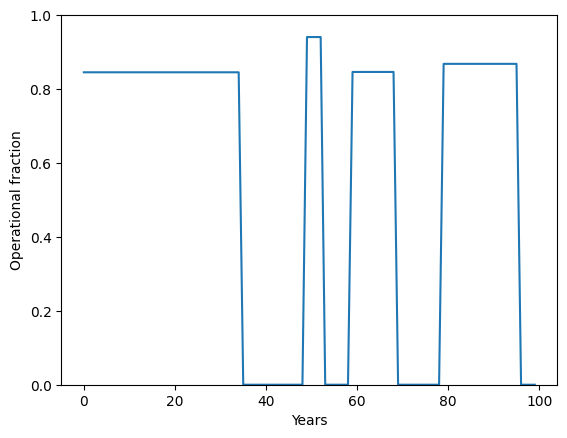

In [ ]:
# Example usage
prob_failure = 0.05
avg_outage_length = 5
total_years = 100
failure_sequence,fracfail = simulate_failure(prob_failure, avg_outage_length, total_years,0.2)
plt.plot(1-fracfail)
plt.ylim([0,1])
plt.ylabel('Operational fraction')
plt.xlabel('Years')

In [ ]:
def adpt_fair(ems,sint,threshold,df,wd=2500,wf=1,i=0,p=None,iters=100):
  if p is None:
    p={}
    p['tcrecs']=np.array([1.6,2.75])
    p['F_scale']=np.ones(13)
    p['r0']=35
    p['rc']=0.02
    p['rt']=4.1
    p['F2x']=3.73
  Ce, Fe, Te = fair.forward.fair_scm(emissions=ems.Emissions.emissions,
                            r0 = p['r0'],
                            rc = p['rc'],
                            rt = p['rt'],
                            tcrecs = p['tcrecs'][:],
                            scale = p['F_scale'][:])
  ems_bs=np.sum(ems.Emissions.emissions[:,1:3],axis=1)
  f_bs=np.sum(Fe[:,1:11], axis=1)
  C45g0, F45g0, T45g0 = fair.forward.fair_scm(emissions=ems_bs,other_rf=f_bs,useMultigas=False,
                            r0 = p['r0'],
                            rc = p['rc'],
                            rt = p['rt'],
                            tcrecs = p['tcrecs'][:],
                            scale = p['F_scale'][0])

  # C0, F0, T0 = fair.forward.fair_scm(emissions=ems_bs*0,other_rf=f_bs*0,useMultigas=False,
  #                           r0 = p['r0'],
  #                           rc = p['rc'],
  #                           rt = p['rt'],
  #                           tcrecs = p['tcrecs'][:],
  #                           scale = p['F_scale'][:],
  #                           F2x = p['F2x'])

  Ttmp1=T45g0
  srm1=f_bs*0
  de=srm1*0
  srm_on=f_bs*0
  srm_act=f_bs*0
  
  
  istart=int(df.loc[i]['Start']-ems.Emissions.emissions[0,0])
  iend=int(df.loc[i]['End']-ems.Emissions.emissions[0,0])
  nyrs=iend-istart
  failure_sequence,fracfail = simulate_failure(df.loc[i]['pfail'], df.loc[i]['aol'], nyrs, df.loc[i]['Effic'])
  srm_on[istart:iend]=1-failure_sequence
  ifade=int(df.loc[i]['fade'])

  ems1=ems_bs.copy()
  for j in np.arange(0,iters):
    Ctmp1, Ftmp1, Ttmp1 = fair.forward.fair_scm(emissions=ems1,other_rf=f_bs+srm1,useMultigas=False,
                            r0 = p['r0'],
                            rc = p['rc'],
                            rt = p['rt'],
                            tcrecs = p['tcrecs'][:],
                            scale = p['F_scale'][0])
    ovsht=(Ttmp1-threshold).clip(min=0)
    srm1=((srm1-ovsht/sint)*srm_on).clip(min=-df.loc[i]['maxsrm'])
    if j<10:
      ems1=np.interp(np.arange(0,len(srm1),1)-np.cumsum(srm_on)*df.mhaz[i],np.arange(0,len(srm1),1),ems_bs)
  srm_act[istart:iend]=srm1[istart:iend]*(fracfail)
  if ifade>0:
    srm_act[iend:(iend+ifade)]=srm_act[iend]*(1-np.arange(0,ifade)/ifade)
 

  Ctmp1, Ftmp1, Ttmp1 = fair.forward.fair_scm(emissions=ems1,other_rf=f_bs+srm_act,useMultigas=False,
                            r0 = p['r0'],
                            rc = p['rc'],
                            rt = p['rt'],
                            tcrecs = p['tcrecs'][:],
                            scale = p['F_scale'][0],
                            F2x = p['F2x'])
  return Ctmp1, Ftmp1, Ttmp1, srm_act, ems1, T45g0


In [ ]:
d = {'name':['SSP1','SSP2','SSP3','SSP4','SSP5'],
     'Start': [2040,2040,2040,2040,2040], 
     'End': [2170,2170,2170,2170,2170], 
     'Effic': [.99,0.9,0.5,0.7,.99], 
     'fade':[20,10,5,10,20], 
     'mhaz':[0,.4,.8,.4,.9], 
     'pfail':[0.0,0.008,0.03,0.015,0.008], 
     'aol':[0,10,10,10,10],
     'maxsrm':[2.0,4.0,4.0,4.0,8.0],
     'regionality':[0.1,.3,.5,0.8,.1]
     }
df = pd.DataFrame(data=d)
df


,name,Start,End,Effic,fade,mhaz,pfail,aol,maxsrm,regionality
0,SSP1,2040,2170,0.99,20,0.0,0.000,0,2.0,0.1
1,SSP2,2040,2170,0.90,10,0.4,0.008,10,4.0,0.3
2,SSP3,2040,2170,0.50,5,0.8,0.030,10,4.0,0.5
3,SSP4,2040,2170,0.70,10,0.4,0.015,10,4.0,0.8
4,SSP5,2040,2170,0.99,20,0.9,0.008,10,8.0,0.1


In [ ]:
sgn=np.array([-1,1,1,1,1])
(1-sgn)/2

array([1., 0., 0., 0., 0.])

In [ ]:
from matplotlib import patches as mpatches

def arrow(self,x, y, dx, dy, **kwargs):
    kwargs.setdefault('arrowstyle', 'simple, head_width=10, head_length=10')
    kwargs.setdefault('fc', 'black')
    x = self.convert_xunits(x)
    y = self.convert_yunits(y)
    dx = self.convert_xunits(dx)
    dy = self.convert_yunits(dy)
    posA = x, y
    posB = x+dx, y+dy
    a = mpatches.FancyArrowPatch(posA=posA, posB=posB, **kwargs)
    self.add_artist(a)
    return a

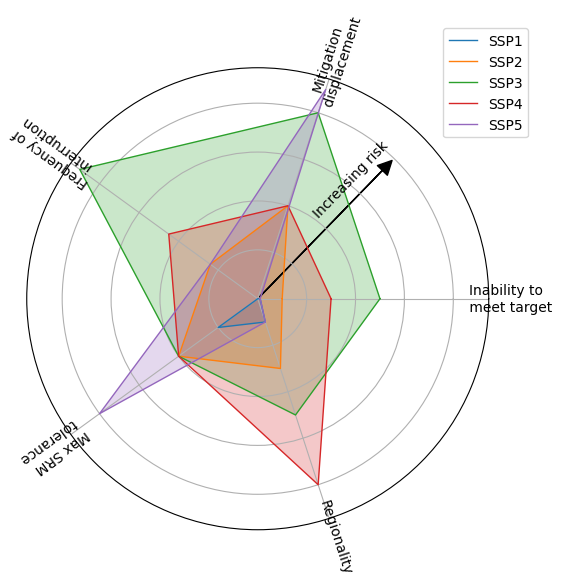

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Define the dimensions to plot
dimensions = ['Effic', 'mhaz', 'pfail', 'maxsrm', 'regionality']
dimlong=["Inability to \n meet target", 'Mitigation\n displacement', 'Frequency of\n interruption', 'Max SRM \n tolerance', 'Regionality']

# Number of variables
num_vars = len(dimensions)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
angles += angles[:1]

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
scl=np.array([1,1,30,.1,1])
sgn=np.array([-1,1,1,1,1])
# Plot each row in the dataframe

for i, row in df.iterrows():
    values = ((1-sgn)/2+sgn*row[dimensions]*scl).tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['name'])
    ax.fill(angles, values, alpha=0.25)

# Add labels to the chart
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimlong)
arrow(ax,0, 0, .8, .8)
ax.text(40/180*np.pi,.5, 'Increasing risk', ha='center', va='bottom',rotation=46)
labels = []

for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    x,y = label.get_position()
    lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    lab.set_rotation(angle/np.pi*180)
    labels.append(lab)
# Add a legend
ax.set_xticklabels([])

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()

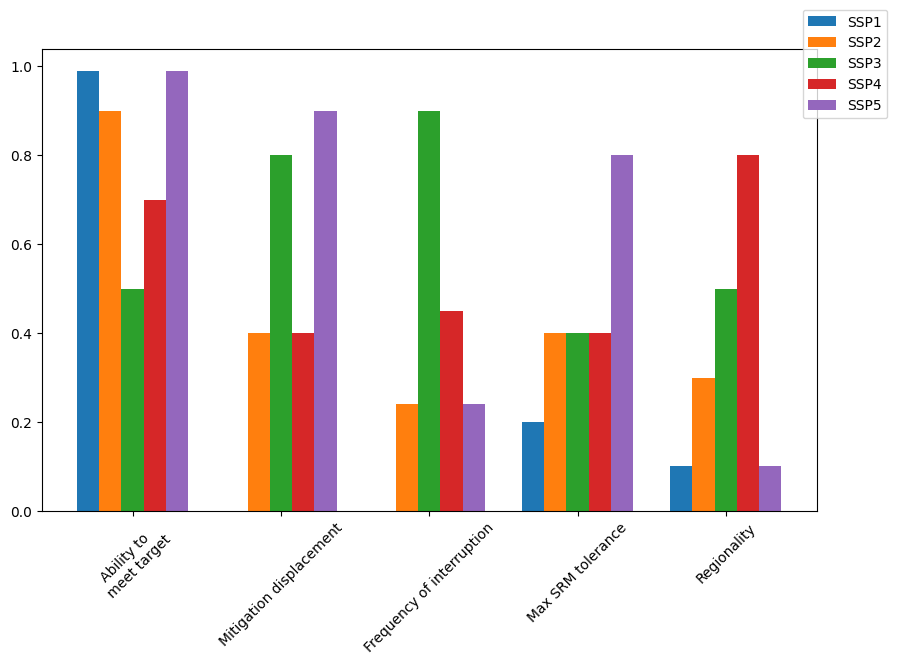

In [ ]:

# Initialize the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Scaling factors
scl = np.array([1, 1, 30, .1, 1])

# Plot each row in the dataframe
bar_width = 0.15
for i, row in df.iterrows():
    values = (row[dimensions] * scl).tolist()
    bar_positions = np.arange(len(dimensions)) + i * bar_width
    ax.bar(bar_positions, values, bar_width, label=row['name'])

# Add labels to the chart
ax.set_xticks(np.arange(len(dimensions)) + bar_width * (len(df) - 1) / 2)
ax.set_xticklabels(dimlong)
plt.xticks(rotation = 45)
# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


In [ ]:
nt=len(ssp3ext.Emissions.emissions)

In [ ]:

Ctmp1s=np.zeros((nt,len(df)))
Ftmp1s=np.zeros((nt,len(df)))
Ttmp1s=np.zeros((nt,len(df)))
srm1s=np.zeros((nt,len(df)))
de=np.zeros((nt,len(df)))
T0tmp1s=np.zeros((nt,len(df)))


for i,n in enumerate(df.name):
     print(i)
     Ctmp1s[:,i], Ftmp1s[:,i], Ttmp1s[:,i], srm1s[:,i], de[:,i], T0tmp1s[:,i]=adpt_fair(ssp3ext,3,1.5,df,i=i,iters=30)

0
1
2
3
4


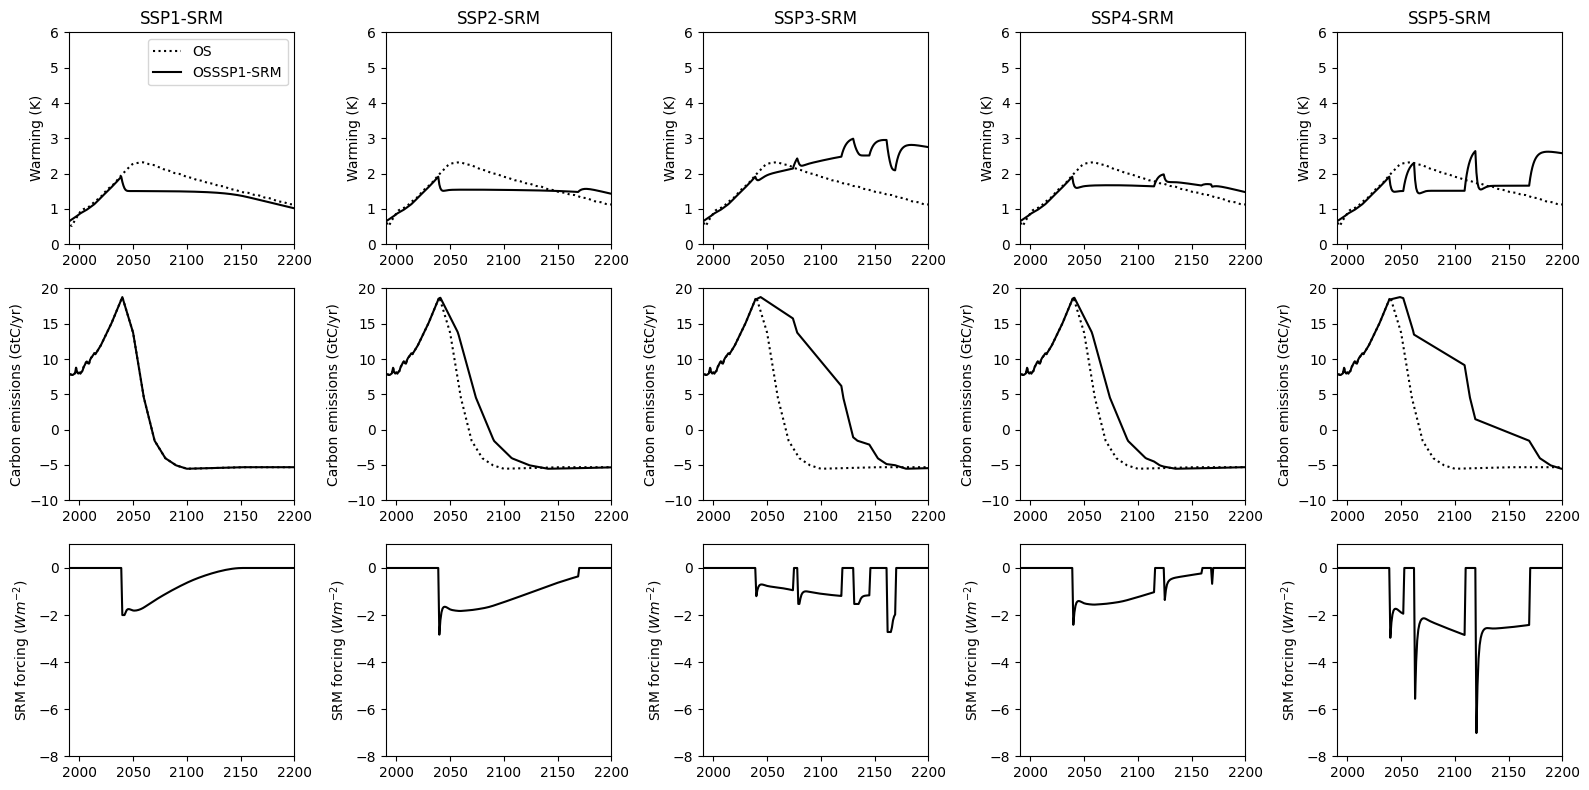

In [ ]:

fig = plt.figure(figsize=(16, 8))

for i,n in enumerate(df.name):

     ax1 = fig.add_subplot(3,5,i+1)
     ax2 = fig.add_subplot(3,5,i+6)
     ax3 = fig.add_subplot(3,5,i+11)
     ax1.plot(yr,T34,'k:',label='OS')
     ax1.plot(yr,Ttmp1s[:,i],'k',label='OS'+df['name'][i]+'-SRM')
     ax1.set_xlim([1990,2200])
     ax1.set_ylim([0,6])
     ax1.set_title(df['name'][i]+'-SRM')
     if i==0:
          ax1.legend()
     ax1.set_ylabel('Warming (K)')

     ax2.plot(yr,ems_bs,'k:',label='OS (FF+LU)')
     ax2.plot(yr,de[:,i],'k',label='Emissions w. SRM effect (FF+LU)')

     #ax2.plot(yr,-gamma*np.diff(T45g0,prepend=0)-beta*np.diff(C45g0,prepend=C34[0,0]),'r',label='land+ocn sink (SSP534-over)')
     #ax2.plot(yr,-gamma*np.diff(Ttmp1s,prepend=0)-beta*np.diff(Ctmp1s,prepend=C34[0,0]),'y',label='land+ocn sink (SSP534-geo)')
     ax2.set_ylabel('Carbon emissions (GtC/yr)')

     #ax2.legend()

     ax2.set_ylim([-10,20])

     #ax2.plot(yr,ems1s,'y')
     ax2.set_xlim([1990,2200])

     ax3.plot(yr,srm1s[:,i],'k')
     #ax3.plot(frf[i],'r')
     
     ax3.set_xlim([1990,2200])

     ax3.set_ylabel('SRM forcing ('+r'$Wm^{-2}$)')
     ax3.set_ylim([-8,1])



plt.tight_layout()


In [ ]:
import sys

In [ ]:
def print_progress_bar(index, total, label):
    n_bar = 50  # Progress bar width
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

In [ ]:
nens=len(pmat[:10])
Cmat=np.zeros((nt,len(df),nens))
Fmat=np.zeros((nt,len(df),nens))
Tmat=np.zeros((nt,len(df),nens))
srmmat=np.zeros((nt,len(df),nens))
demat=np.zeros((nt,len(df),nens))
T0mat=np.zeros((nt,len(df),nens))



for j in range(nens):
    
    for i,n in enumerate(df.name):
          
        print_progress_bar((i+j*len(df)), (len(df)*nens), "Simulating")
        Cmat[:,i,j], Fmat[:,i,j], Tmat[:,i,j], srmmat[:,i,j], demat[:,i,j],T0mat[:,i,j] =adpt_fair(ssp3ext,5,1.5,df,i=i,p=pmat[j],iters=50)
     


[                                                  ] 0%  Simulating

KeyError: 'F2x'

(1990.0, 2200.0)

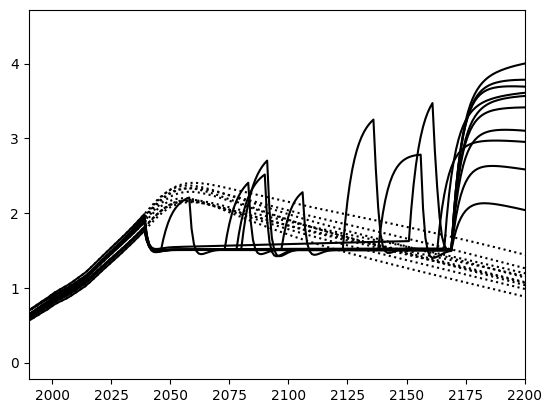

In [ ]:
#plt.plot(yr,T34,'k:',label='OS')
plt.plot(yr,Tmat[:,4,:],'k',label='OS'+df['name'][i]+'-SRM')
plt.plot(yr,T0mat[:,4,:],'k:',label='OS'+df['name'][i]+'-SRM')

plt.xlim([1990,2200])
#plt.plot(yr,Ttmp1s[:,0])

In [ ]:
def compute_damages(temperature_series, dt=1.0, a=0.002, b=0.001, c=0.0005, D0=0.0):
    """
    Compute time series of damages as a function of global mean temperature anomaly and its rate of change.
    
    Parameters:
    ----------
    temperature_series : array-like or pd.Series
        Time series of global mean temperature anomalies (°C).
    dt : float
        Time step between temperature observations (years). Default is 1.0 (annual data).
    a, b, c : float
        Coefficients for temperature level, rate of change, and interaction terms.
    D0 : float
        Baseline damage (can be set to 0 if not needed).
        
    Returns:
    -------
    damages : np.ndarray
        Time series of computed damages.
    dT_dt : np.ndarray
        Rate of change of temperature anomaly.
    """
    
    T = np.asarray(temperature_series)
    
    # Compute rate of temperature change (central differences)
    dT_dt = np.zeros_like(T)
    dT_dt[1:-1] = np.abs(T[2:] - T[:-2]) / (2 * dt)
    dT_dt[0] = (T[1] - T[0]) / dt  # Forward difference at start
    dT_dt[-1] = (T[-1] - T[-2]) / dt  # Backward difference at end
    
    # Compute damages
    damages = D0 + a * T**2 + b * dT_dt**2 + c * T * dT_dt
    
    return damages, dT_dt

 Parameter Set    | `a` (Level Term) | `b` (Rate Term) | `c` (Interaction Term) | `D₀` (Baseline) | Supporting References and Rationale |
|------------------|------------------|-----------------|------------------------|-----------------|-------------------------------------|
| **Conservative** | 0.0023           | 0.001           | 0.01                   | 0.0             | **DICE-2016R** (Nordhaus, 2017) for level damages; minimal rate and interaction terms to align with standard IAM assumptions. |
| **Moderate**     | 0.0028           | 0.005           | 0.025                  | 0.0             | **Lemoine & Traeger (2014)** for rate sensitivity; **Glanemann et al. (2020)** on combined level-rate damages; slightly higher `a` reflecting **Burke et al. (2015)**'s evidence on higher GDP sensitivity to temperature. |
| **High-risk**    | 0.0035           | 0.015           | 0.05                   | 0.0             | **Daniel et al. (2019)** and **Lemoine & Traeger (2014)** on tipping risks and rate-dependence; **precautionary** parameterization to capture high-end damage scenarios and adaptation limits. |

In [ ]:
damage_parameter_sets = {
    "conservative": {"a": 0.0023, "b": 0.00, "c": 0.0, "D0": 0.0},
    "moderate":     {"a": 0.0028, "b": 0.005, "c": 0.025, "D0": 0.0},
    "high-risk":    {"a": 0.0035, "b": 0.015, "c": 0.05, "D0": 0.0},
}



In [ ]:
def calc_damages(T,damage_parameter_sets):
    damages = {}
    for key, params in damage_parameter_sets.items():
        damages[key], dT_dt = compute_damages(T, a=params["a"], b=params["b"], c=params["c"], D0=params["D0"])

    return damages

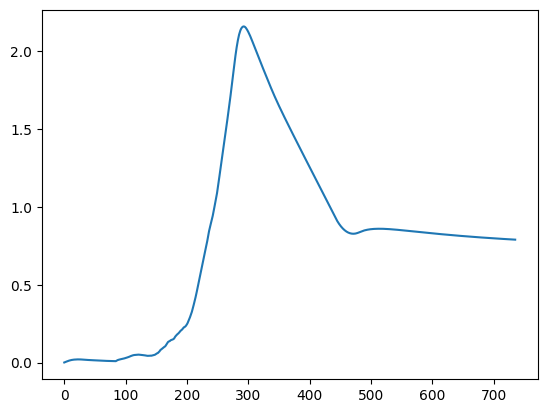

In [ ]:
plt.plot(T0mat[:,4,0])

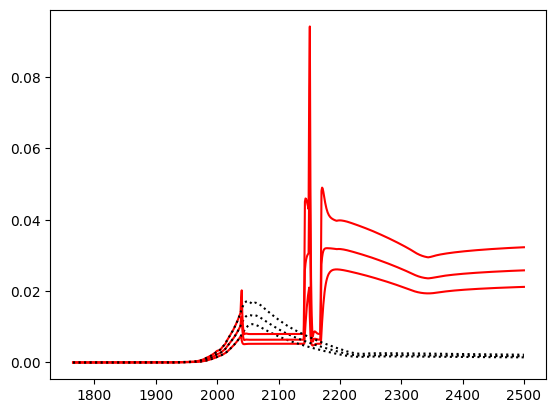

In [ ]:
dmg=calc_damages(Tmat[:,4,0],damage_parameter_sets)
dmg0=calc_damages(T0mat[:,4,0],damage_parameter_sets)

for key in damage_parameter_sets.keys():
    plt.plot(yr,dmg[key],label=key,color='r')
    plt.plot(yr,dmg0[key],label=key,color='k',linestyle=':')

| Approach                        | Discount Rate Formulation                             | Default Parameter Values                                   | Key References and Rationale                                                |
|---------------------------------|-----------------------------------------------------|-----------------------------------------------------------|------------------------------------------------------------------------------|
| **Standard IAM Assumptions**    | Constant discount rate                             | `ρ = 0.02` (2% per year)                                   | **DICE-2016R** (Nordhaus, 2017); typical in **FUND**, **PAGE**; reflects standard cost-benefit IAM practice.                 |
| **Ethical Alternative (Ramsey)** | Endogenous: `ρ(t) = ρ₀ + η × g`                    | `ρ₀ = 0.001` (0.1% pure time preference), `η = 1.5` (elasticity of marginal utility), `g = 0.015` (1.5% per capita growth) | **Stern Review (2007)** recommends low `ρ₀`; **Lemoine & Traeger (2014)** discuss ethical and precautionary implications; **Pindyck (2012)** on uncertainty and ethics in discounting. |

In [ ]:
yr[260]

np.float64(2025.0)

In [ ]:
def integrate_damages(
    damages,
    method="standard",
    dt=1.0,
    rho_const=0.02,              # Standard IAM constant discount rate
    rho_0_ramsey=0.001,          # Ramsey pure rate of time preference
    eta_ramsey=1.,              # Ramsey elasticity of marginal utility
    growth_rate=0.007,            # Per capita consumption growth rate
    tstart=260
):
    """
    Integrate climate damages over time with two alternative discounting approaches.
    
    Parameters:
    ----------
    damages : array-like
        Time series of damages as fraction of GDP.
    method : str
        Discounting method: "standard" (constant rate) or "ethical" (Ramsey-type).
    dt : float
        Time step (years).
    rho_const : float
        Constant discount rate (used if method="standard").
    rho_0_ramsey : float
        Pure time preference rate (used if method="ethical").
    eta_ramsey : float
        Elasticity of marginal utility of consumption (used if method="ethical").
    growth_rate : float
        Per capita consumption growth rate (used if method="ethical").
    
    Returns:
    -------
    pv_damages : float
        Present value of integrated damages (as fraction of GDP).
    discount_factors : np.ndarray
        Discount factor time series.
    """
    damages = np.asarray(damages)
    #T = np.tile(np.arange(len(damages)) * dt, (damages.shape[1],1))
    T = np.arange(len(damages)) * dt
    if method == "standard":
        # Constant discounting
        discount_factors = np.exp(-rho_const * T)
    
    elif method == "ethical":
        # Ramsey discounting
        rho_t = rho_0_ramsey + eta_ramsey * growth_rate
        cumulative_discount = np.cumsum(np.full_like(T, rho_t) * dt)
        discount_factors = np.exp(-cumulative_discount)
    
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'ethical'.")
    if damages.ndim>1:
        discount_factors=np.repeat(discount_factors[:,None], damages.shape[1], axis=1)
    # Present value of damages
    pv_damages = np.sum(damages[tstart:] * discount_factors[:len(damages[tstart:])],axis=0) * dt
    
    return pv_damages, discount_factors

In [ ]:
def icalc_damages(T,damage_parameter_sets):
    idamages = {}
    damages = calc_damages(T,damage_parameter_sets)
    for key in damage_parameter_sets.keys():
        idamages[key+'_standard'], discount_factors = integrate_damages(damages[key], method="standard")
    for key in damage_parameter_sets.keys():

        idamages[key+'_ethical'], discount_factors = integrate_damages(damages[key], method="ethical")

    return idamages

In [ ]:
dmg=pd.DataFrame(icalc_damages(Tmat[:,4,:],damage_parameter_sets))
dmg0=pd.DataFrame(icalc_damages(T0mat[:,4,:],damage_parameter_sets))


<Axes: >

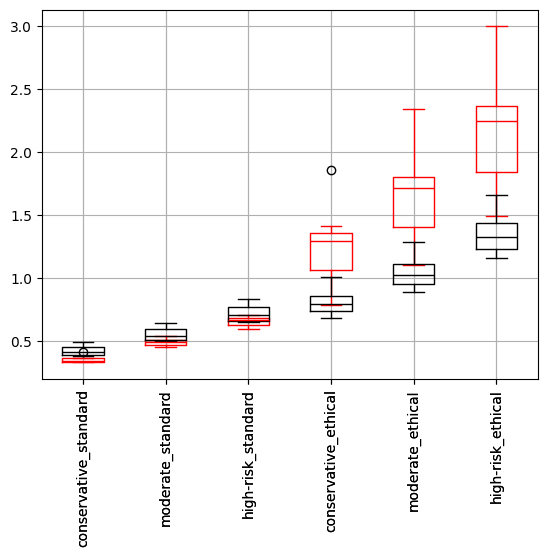

In [ ]:
dmg.boxplot(rot=90,color='r')
dmg0.boxplot(rot=90,color='k')
